# Arrival Time Prediction - Pre Processing
This notebook is the first on the work on GP regression for arrival time prediction and deals with the pre processing before a model can be trained to make predictions.

First off lets get some libraries into scope and load the data.

In [40]:
import numpy as np
import pandas as pd
import time
import pickle
from datetime import datetime
from functools import reduce
import plot

data = pd.read_csv('../../bus203_all.csv')
data = data[data.journey_number < 10]
data.head()

,Unnamed: 0,timestamp,event,vehicle_id,line,longitude,latitude,direction,speed,station,journey_number,segment_number
8088,920,2018-02-16T07:05:36.0000000+01:00,ObservedPositionEvent,5486,0,58.407898,15.602301,78.800003,7.66,NaN,9,11
8089,921,2018-02-16T07:05:37.0000000+01:00,ObservedPositionEvent,5486,0,58.407913,15.602435,78.190002,8.12,NaN,9,11
8090,922,2018-02-16T07:05:38.0000000+01:00,ObservedPositionEvent,5486,0,58.407928,15.602587,78.099998,8.64,NaN,9,11
8091,923,2018-02-16T07:05:39.0000000+01:00,ObservedPositionEvent,5486,0,58.407948,15.602742,76.500000,9.10,NaN,9,11
8092,924,2018-02-16T07:05:39.0000000+01:00,EnteredEvent,5486,203,58.407948,15.602742,-1.000000,-1.00,Parkgatan Link\xf6ping,9,11


The names in the csv are very verbose, so we'll shorten them. This is of course a matter of preference but I prefer it this way.

In [41]:
data = data.rename(columns = {
                        'latitude': 'lat', 
                        'longitude': 'lon', 
                        'journey_number': 'traj', 
                        'segment_number': 'seg', 
                        'speed': 'speed', 
                        't': 't'})
data.head()

,Unnamed: 0,timestamp,event,vehicle_id,line,lon,lat,direction,speed,station,traj,seg
8088,920,2018-02-16T07:05:36.0000000+01:00,ObservedPositionEvent,5486,0,58.407898,15.602301,78.800003,7.66,NaN,9,11
8089,921,2018-02-16T07:05:37.0000000+01:00,ObservedPositionEvent,5486,0,58.407913,15.602435,78.190002,8.12,NaN,9,11
8090,922,2018-02-16T07:05:38.0000000+01:00,ObservedPositionEvent,5486,0,58.407928,15.602587,78.099998,8.64,NaN,9,11
8091,923,2018-02-16T07:05:39.0000000+01:00,ObservedPositionEvent,5486,0,58.407948,15.602742,76.500000,9.10,NaN,9,11
8092,924,2018-02-16T07:05:39.0000000+01:00,EnteredEvent,5486,203,58.407948,15.602742,-1.000000,-1.00,Parkgatan Link\xf6ping,9,11


## Computing arrival times
The goal is to estimate arrival time given a trajectory, but to do that we first need to annotate the trajectories in the data with the actual arrival times. We do this by creating a dictionary which maps trajectories to arrival times and save it for later.

In [3]:
def parse_time(dt_str):
    dt, _, _ = dt_str.partition(".")
    return datetime.strptime(dt, "%Y-%m-%dT%H:%M:%S")

def traj_travel_time(data, traj):
    traj_data = data[data.traj == traj]
    segs = traj_data.seg.unique()
    return {seg : seg_travel_time(traj_data, seg) for seg in segs}

def seg_travel_time(traj_data, seg):
    seg_data = traj_data[traj_data.seg == seg]
    start_time = parse_time(seg_data.iloc[0].timestamp)
    arrival_time = parse_time(seg_data.iloc[-1].timestamp)
    return arrival_time - start_time

t0 = time.time()
trajs = data.traj.unique()
travel_times = {traj : traj_travel_time(data, traj) for traj in trajs}
elapsed = time.time() - t0

with open('travel_times.pkl', 'wb') as handle:
    pickle.dump(travel_times, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Data processed in", elapsed, " seconds")

Data processed in 0.07579636573791504  seconds


In addition to knowing the arrival times when making predictions, we are going to need to know the _progression_ of each trajectory. This is needed to train a synchronisation GP before making the predictions. The following chunk annotates the data with normalised temporal progression. Beware that this takes a while! It took me 20 minutes on an i7 processor.

In [45]:
t0 = time.time()
progress = pd.DataFrame({'progress': np.zeros(data.shape[0])})
reverse_rows = data.iloc[::-1]
last_stop_timestamp = parse_time(reverse_rows.iloc[0].timestamp)
for i, d in reverse_rows.iterrows():
    t = parse_time(d.timestamp)
    if d.event == 'EnteredEvent':
        last_stop_timestamp = t
    progress.iloc[i] = 1 - (((last_stop_timestamp - t).seconds) / travel_times[d.traj][d.seg].seconds)

progress_data = pd.concat([
            data['lat'], 
            data['lon'], 
            data['traj'], 
            data['seg'], 
            data['speed'], 
            progress],
            axis = 1)

print("Data processed in", elapsed, " seconds")
elapsed = time.time() - t0
progress_data[progress_data.traj == 1]

Data processed in 1.738539457321167  seconds


,lat,lon,traj,seg,speed,progress
0,15.571015,58.414238,1,1,-1.00,0.000000
1,15.571015,58.414238,1,1,0.00,0.000000
2,15.571015,58.414238,1,1,-1.00,0.000000
3,15.571012,58.414246,1,1,0.00,0.013889
4,15.571008,58.414249,1,1,0.00,0.027778
5,15.571004,58.414257,1,1,0.00,0.041667
6,15.571006,58.414257,1,1,0.00,0.055556
7,15.571008,58.414261,1,1,0.00,0.069444
8,15.571010,58.414261,1,1,0.00,0.083333
9,15.571012,58.414261,1,1,0.00,0.097222


## Stop Compression
There are many times where busses stop or drive very slowly. This causes a lot of data points to be clustered which will cause the GPs to prioritise getting the clustered areas right more than other areas, which we do not want. To prevent this we will filter out data points in every trajectory that are too close by some delta. However simply throwing the points aray will leave massive gaps in between them, which will not work at all for a GP with constant kernel lengthscale (which we will use). To combat this we will compress the data points during stops to a single data point which takes the mean value.

Worth noting is that coordinates are not in euclidian space but on a spherical surface so pythagoras theorem is no good here and we have to turn to haversine distance.

In [46]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers
    return c * r

def as_dict(d):
    return {
        'lat': d.lat,
        'lon': d.lon,
        'seg': d.seg,
        'speed': d.speed,
        'progress': d.progress,
        'traj': d.traj
    }

def compress(data):
    df = pd.DataFrame(data)
    df.speed = np.max(df.speed, 0) # data contains -1 sentinel values for missing speed
    df = df.apply(np.mean, axis=0)
    return as_dict(df)
    
t0 = time.time()

# Iterate through all data points, compare with latest 
# in resampled_data and append if it the distance is larger than 
# haversine delta. We also always append the final point, to make sure
# the trajectory is always complete.
delta = 4e-3 # approx. 4 metres
stop_list = []
rows = [as_dict(progress_data.iloc[0])]
for i, d in progress_data.iterrows():
    di = rows[len(rows)-1]
    if haversine(d.lat, d.lon, di.get('lat'), di.get('lon')) < delta:
        stop_list.append(as_dict(d))
    else:
        if stop_list:
            rows.append(compress(stop_list))
        stop_list = []
        rows.append(as_dict(d))
        
    #if haversine(d.lat, d.lon, di.get('lat'), di.get('lon')) > delta or d.progress == 1:
    #    rows.append(as_dict(d))

resampled_data = pd.DataFrame(rows)

elapsed = time.time() - t0
print("Data processed in", elapsed, " seconds")
resampled_data

Data processed in 1.4780480861663818  seconds


,lat,lon,progress,seg,speed,traj
0,15.571015,58.414238,0.000000,1.0,-1.00,1.0
1,15.571012,58.414258,0.085784,1.0,0.00,1.0
2,15.571187,58.414196,0.194444,1.0,-1.00,1.0
3,15.571016,58.414265,0.208333,1.0,0.41,1.0
4,15.571037,58.414248,0.236111,1.0,1.18,1.0
5,15.571072,58.414230,0.263889,1.0,1.49,1.0
6,15.571098,58.414215,0.277778,1.0,1.69,1.0
7,15.571137,58.414204,0.291667,1.0,2.31,1.0
8,15.571187,58.414196,0.298611,1.0,2.57,1.0
9,15.571241,58.414196,0.319444,1.0,2.72,1.0


We can see that the majority of the points that are removed are taken from the start of trajectories, which makes sense since the bus has a lot of dwell time and slow speed in the beginning. We also see a huge problem with the first route. The buss has a _massive_ dwell time on this point, more than half the time spent on the segment. This makes predictions very hard.

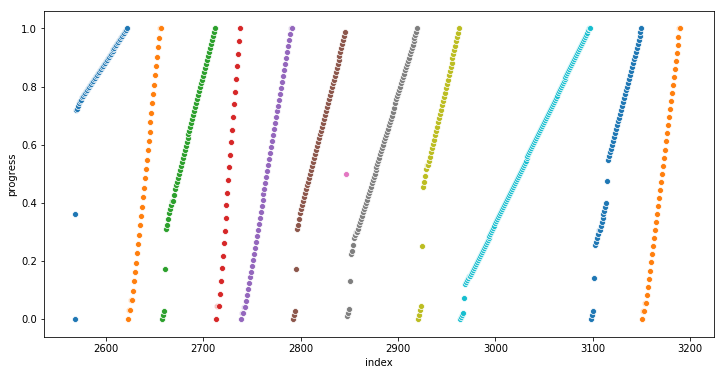

In [47]:
traj_to_plot = resampled_data[resampled_data.traj == 5]
plot.traj_progress(traj_to_plot)

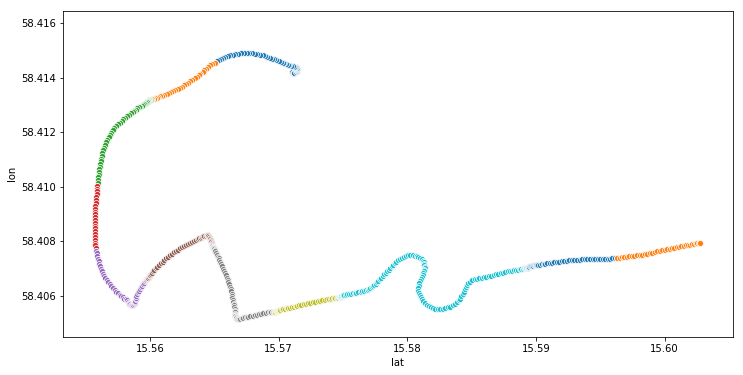

In [48]:
plot.traj_segments(traj_to_plot)

## Filter outlier
Plotting the data show one outlier, how it got there is beyond me, but we filter it out.

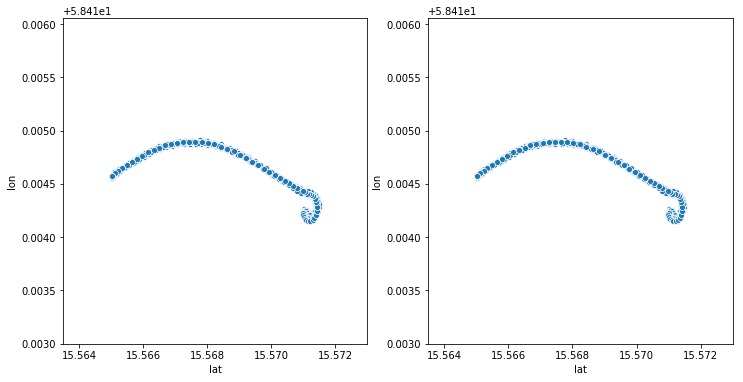

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
seg = resampled_data[resampled_data.seg == 1]
sns.scatterplot(x="lat", y="lon", data=seg, ax=ax[0])

d = resampled_data # just a shorted name for the query
filtered_data = d[((d.lat > 15.562) & (d.seg == 1)) | (d.seg != 1)]       
seg = filtered_data[filtered_data.seg == 1]
sns.scatterplot(x="lat", y="lon", data=seg, ax=ax[1])

## Enforce smoothness
A property that we want from the synchroinisation GP that we will train is for it to be a smooth mapping with respect to spatial progress, that is, we want regions that are close progressionwise in the functions domain to be close in its codomain. This is not something a GP guarantees at all, so to force it to learn something closer to what we want the data is duplicated with a small offset orthogonal to progression. We call these data points support data points, and they are saved in their own data set.

This is meaningful only for training data, so at this point we split the data into train and test sets.

In [94]:
n_trajs = len(filtered_data.traj.unique())
n_train = round(n_trajs*0.8)
train_ixs = frozenset(np.random.randint(0, n_trajs-1, n_train))

train_data = filtered_data[filtered_data.traj.transform(lambda x: x in train_ixs)]
test_data = filtered_data[filtered_data.traj.transform(lambda x: x not in train_ixs)]
train_data.to_pickle('train.pkl')
test_data.to_pickle('test.pkl')

C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


Data processed in 0.6074023246765137  seconds


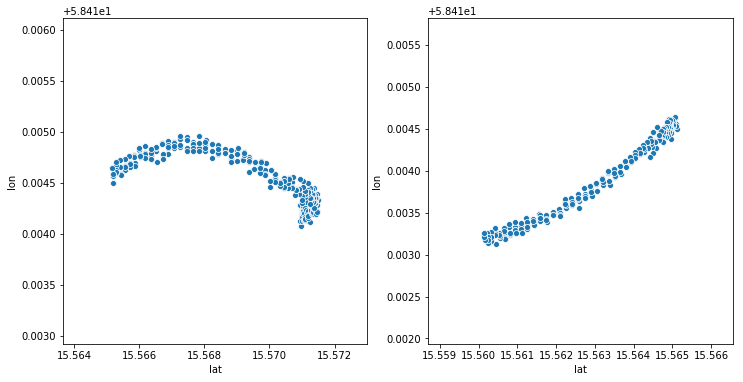

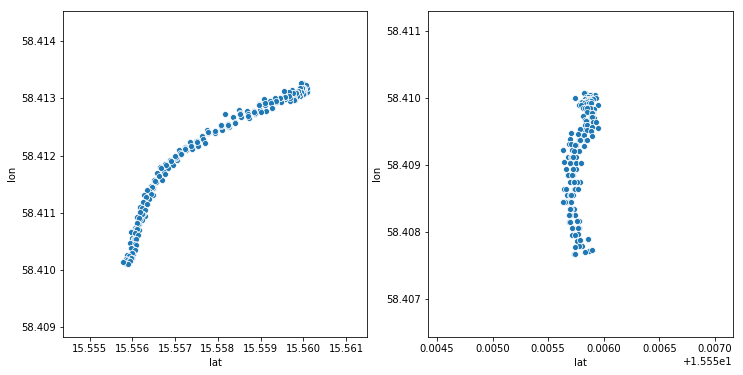

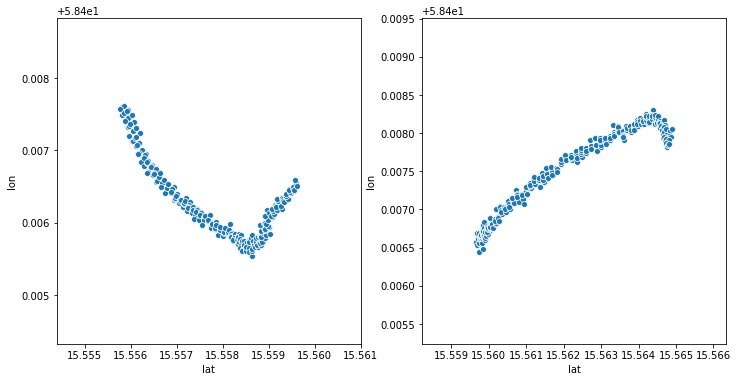

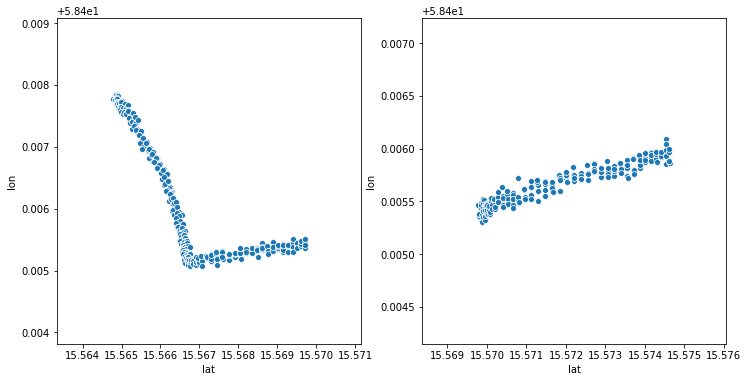

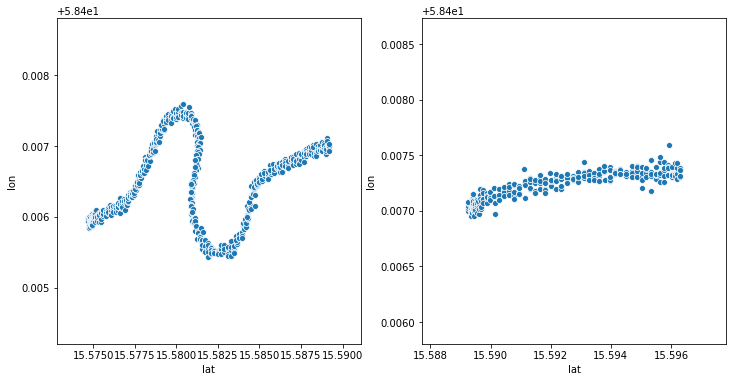

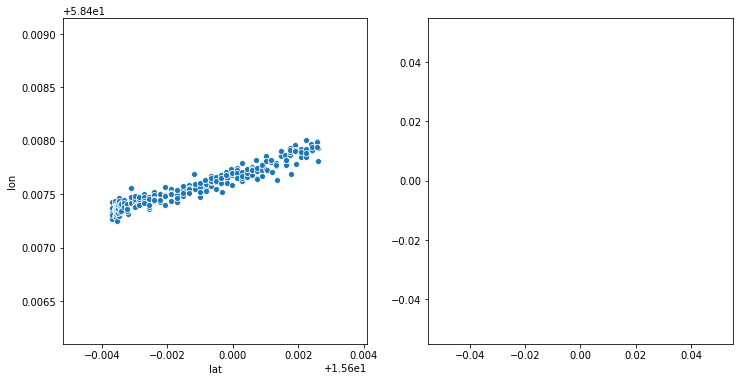

In [103]:
from numpy.linalg import norm
tmp_data = []
train_data = train_data[train_data.traj == train_data.traj.unique()[0]]
N = train_data.shape[0]
t0 = time.time()
d = 5 # amount of random draws
for n in range(N-1):
    cur = train_data.iloc[n]
    nxt = train_data.iloc[n+1]
    d_lat = nxt.lat - cur.lat
    d_lon = nxt.lon - cur.lon
    
    v = np.array([cur.lat, cur.lon]) # current data point position
    u = np.array([-d_lon, d_lat])    # orthogonal to progression 
    u = u/norm(u)
    sigma = 5e-5 # taken by simply looking at the results for something that looks decent
    draws = np.random.normal(0, sigma, d)
    support_latlon = [v + u*draw for draw in draws]
    
    def offset(data, lat, lon):
        data.lat = lat
        data.lon = lon
        return data
    
    support_data  = [offset(cur.copy(), lat, lon) for lat, lon in support_latlon]
    tmp_data = tmp_data + support_data
    
support_data = pd.DataFrame(tmp_data)
support_data.to_pickle('support.pkl')

elapsed = time.time() - t0
print("Data processed in", elapsed, " seconds")

plot.traj_segment_grid(support_data, 'lat', 'lon')

In [76]:
np.random.normal(1, 2, 2)

array([ 2.55524465e+00, -1.18797131e-05])